In [1]:
# XGBoost to Multi-Language Converter
# Converts XGBoost models to various programming languages for zero-knowledge proofs

import pandas as pd
import numpy as np
import json
import os
import functions as fn
import cached_features as cf
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

# ============ CONFIGURATION ============
# Language selection - change this to convert to different target languages
TARGET_LANGUAGE = 'rust'  # Options: 'zokrates', 'solidity', 'circom', 'rust', etc.

# Output organization
OUTPUTS_BASE_DIR = 'outputs'
MAINTAIN_BACKWARD_COMPATIBILITY = True  # If True, also outputs to current directory for ZoKrates

# Model and tree configuration
MODEL_PATH = '../models/'
SUFFIX = '_final_subm'
TREE_LIMITS = [10, 20, 50, 100, 150, 200, 250, 300]

print(f"XGBoost to {TARGET_LANGUAGE.title()} Converter initialized")
print(f"Output directory: {OUTPUTS_BASE_DIR}/{TARGET_LANGUAGE}/")

XGBoost to Rust Converter initialized
Output directory: outputs/rust/


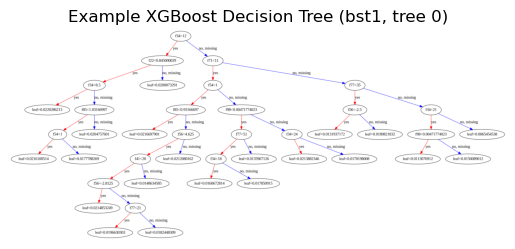

In [2]:
# Example: Load and visualize a decision tree
bst1 = fn.load_xgb_model(MODEL_PATH + 'bst1_1' + SUFFIX)
plot_tree(bst1, tree_idx=0)
plt.title("Example XGBoost Decision Tree (bst1, tree 0)")
plt.savefig("example_tree_bst1_1.pdf")
plt.show()

In [3]:
# Initialize the generalized language converter
from xgb_language_converter import XGBoostLanguageConverter

# Create converter instance for target language
converter = XGBoostLanguageConverter(TARGET_LANGUAGE)
print(f"{TARGET_LANGUAGE.title()} converter initialized successfully")

# Create output directory structure
def ensure_output_directories():
    """Create necessary output directories for the target language."""
    language_output_dir = os.path.join(OUTPUTS_BASE_DIR, TARGET_LANGUAGE)
    os.makedirs(language_output_dir, exist_ok=True)
    print(f"Output directory ensured: {language_output_dir}")
    return language_output_dir

# Set up directories
output_dir = ensure_output_directories()

Rust converter initialized successfully
Output directory ensured: outputs/rust


In [4]:
# Generalized wrapper functions for data conversion
def convert_test_data_to_field_list(test_col):
    """Convert test data to target language field format using the converter."""
    return converter.convert_test_data_to_field_list(test_col)

def get_feature_names_and_instr(model_num, use_xtra_features=False):
    """Get cached feature names and instruction vectors."""
    return cf.load_feature_names_and_instr_from_cache(model_num, use_xtra_features)

# ============ BACKWARD COMPATIBILITY ============
# ZoKrates-specific helper functions (deprecated - use generic functions above)
def convert_test_data_to_field_list_zokrates(test_col):
    """DEPRECATED: Use convert_test_data_to_field_list() instead."""
    print("Warning: convert_test_data_to_field_list_zokrates() is deprecated. Use convert_test_data_to_field_list()")
    if TARGET_LANGUAGE == 'zokrates':
        return convert_test_data_to_field_list(test_col)
    else:
        raise ValueError(f"ZoKrates-specific function called but TARGET_LANGUAGE is '{TARGET_LANGUAGE}'")

In [5]:
# Main function: Convert XGBoost model to target language code
def convert_model_to_language(model_num, use_xtra_features=False, language=None):
    """
    Convert a single XGBoost model to target language code for all tree limits.
    
    Args:
        model_num (int): Model number (1-5)
        use_xtra_features (bool): Whether to use extra features (models 4-5 only)
        language (str, optional): Override target language (defaults to TARGET_LANGUAGE)
    
    Returns:
        dict: Generated files and their paths
    """
    target_lang = language or TARGET_LANGUAGE
    print(f"Converting model {model_num} to {target_lang} (extra_features={use_xtra_features})")
    
    # Get feature names and instruction data (cached for speed)
    feature_names, instr = get_feature_names_and_instr(model_num, use_xtra_features)
    
    # Determine model path and output suffix
    if model_num in [4, 5] and not use_xtra_features:
        model_path = MODEL_PATH + f'bst{model_num}_1{SUFFIX}_no_xtra_features'
        file_suffix = "_no_use_xtra_features"
    else:
        model_path = MODEL_PATH + f'bst{model_num}_1{SUFFIX}'
        file_suffix = ""
    
    # Load XGBoost model
    bst = fn.load_xgb_model(model_path)
    
    # Create output paths
    feature_filename = f"bst{model_num}_feature_names{file_suffix}.txt"
    instr_filename = f"bst{model_num}_instr{file_suffix}.txt"
    
    # Save to language-specific directory
    feature_path = os.path.join(output_dir, feature_filename)
    instr_path = os.path.join(output_dir, instr_filename)
    
    with open(feature_path, "w") as f:
        f.write(str(feature_names))
    with open(instr_path, "w") as f:
        f.write(instr)
    
    # Backward compatibility: also save to current directory for ZoKrates
    if MAINTAIN_BACKWARD_COMPATIBILITY and target_lang == 'zokrates':
        with open(feature_filename, "w") as f:
            f.write(str(feature_names))
        with open(instr_filename, "w") as f:
            f.write(instr)
    
    # Generate code for different tree limits
    generated_files = []
    generated_files_full_path = []
    
    for tree_limit in TREE_LIMITS:
        print(f"  Generating code with {tree_limit} trees...")
        
        # Convert using the appropriate language converter
        code = converter.convert_xgboost_to_code(bst, feature_names, tree_limit)
        
        # Determine file extension from converter config
        file_ext = converter.config["file_extension"]
        filename = f"bst{model_num}_{tree_limit}{file_suffix}{file_ext}"
        file_path = os.path.join(output_dir, filename)
        
        # Save to language-specific directory
        with open(file_path, "w") as f:
            f.write(code)
        generated_files.append(filename)
        generated_files_full_path.append(file_path)
        
        # Backward compatibility: also save to current directory for ZoKrates
        if MAINTAIN_BACKWARD_COMPATIBILITY and target_lang == 'zokrates':
            with open(filename, "w") as f:
                f.write(code)
    
    print(f"Model {model_num} conversion to {target_lang} complete!")
    return {
        'language': target_lang,
        'feature_file': feature_path,
        'instr_file': instr_path, 
        'generated_files': generated_files_full_path,
        'output_directory': output_dir
    }

# ============ BACKWARD COMPATIBILITY ============
def convert_model_to_zokrates(model_num, use_xtra_features=False):
    """DEPRECATED: Use convert_model_to_language() instead."""
    print("Warning: convert_model_to_zokrates() is deprecated. Use convert_model_to_language()")
    if TARGET_LANGUAGE != 'zokrates':
        print(f"Warning: TARGET_LANGUAGE is '{TARGET_LANGUAGE}' but calling ZoKrates-specific function")
    return convert_model_to_language(model_num, use_xtra_features, 'zokrates')

In [6]:
# Execute: Convert all models to target language
print(f"Starting model conversion process to {TARGET_LANGUAGE}...\n")

# Models 1-3: Standard models (no extra features)
for model_num in [1, 2, 3]:
    convert_model_to_language(model_num, use_xtra_features=False)
    print()

# Models 4-5: High-capacity models (both with and without extra features) 
for model_num in [4, 5]:
    # With extra features (full model)
    convert_model_to_language(model_num, use_xtra_features=True)
    print()
    
    # Without extra features (reduced model)
    convert_model_to_language(model_num, use_xtra_features=False) 
    print()

print(f"All model conversions to {TARGET_LANGUAGE} completed successfully!")
print(f"Output files are located in: {output_dir}")
if MAINTAIN_BACKWARD_COMPATIBILITY and TARGET_LANGUAGE == 'zokrates':
    print("Files also saved to current directory for backward compatibility")

Starting model conversion process to rust...

Converting model 1 to rust (extra_features=False)
  Generating code with 10 trees...
  Generating code with 20 trees...
  Generating code with 50 trees...
  Generating code with 100 trees...
  Generating code with 150 trees...
  Generating code with 200 trees...
  Generating code with 250 trees...
  Generating code with 300 trees...
Model 1 conversion to rust complete!

Converting model 2 to rust (extra_features=False)
  Generating code with 10 trees...
  Generating code with 20 trees...
  Generating code with 50 trees...
  Generating code with 100 trees...
  Generating code with 150 trees...
  Generating code with 200 trees...
  Generating code with 250 trees...
  Generating code with 300 trees...
Model 2 conversion to rust complete!

Converting model 3 to rust (extra_features=False)
  Generating code with 10 trees...
  Generating code with 20 trees...
  Generating code with 50 trees...
  Generating code with 100 trees...
  Generating code

In [7]:
# Test: Multi-language conversion validation
def test_language_conversion(language=None, model_num=1):
    """Test conversion functionality for specified language."""
    test_language = language or TARGET_LANGUAGE
    print(f"Testing {test_language} conversion with model {model_num}...")
    
    # Create converter for test language
    test_converter = XGBoostLanguageConverter(test_language)
    
    # Get test data
    test_features, test_instr = get_feature_names_and_instr(model_num, False)
    print(f"✓ Loaded {len(test_features)} features")
    
    # Load model and convert with just 2 trees for testing
    test_bst = fn.load_xgb_model(MODEL_PATH + f'bst{model_num}_1' + SUFFIX)
    test_code = test_converter.convert_xgboost_to_code(test_bst, test_features, 2)
    print(f"✓ Generated {test_language} code: {len(test_code)} characters")
    
    # Language-specific validation
    if test_language == 'zokrates':
        # ZoKrates-specific checks
        assert "struct i64" in test_code, "Missing i64 struct definition"
        assert "def main" in test_code, "Missing main function"
        assert "def i64_le" in test_code, "Missing comparison function"
        assert "def i64_add" in test_code, "Missing addition function"
        assert "f[" in test_code, "Missing proper array indexing"
        print("✓ ZoKrates-specific structure checks passed")
        
        # Test data conversion functions
        test_value = 0.0220286213
        expected_scaled = int(np.round(test_value * 10000000000, 0))
        converted = test_converter.convert_number_to_fixed_point_from_scaled(expected_scaled)
        expected_format = "i64{sgn:true, v: 220286213}"
        assert converted == expected_format, f"Expected {expected_format}, got {converted}"
        print(f"✓ Data conversion test: {test_value} -> {converted}")
    
    elif test_language == 'rust':
        # Rust-specific checks for custom fixed-point implementation
        assert "const PRECISION_MULTIPLIER: i64 = 10_000_000_000;" in test_code, "Missing precision constant"
        assert "fn fixed_le(a: i64, b: i64) -> bool" in test_code, "Missing comparison function"
        assert "fn fixed_add(a: i64, b: i64) -> i64" in test_code, "Missing addition function"
        assert "fn from_scaled_i64(scaled_value: i64) -> i64" in test_code, "Missing scaling function"
        assert "pub fn xgboost_predict(features: &[i64]) -> i64" in test_code, "Missing main function"
        assert "fixed_le(f[" in test_code, "Missing proper function calls"
        assert "from_scaled_i64(" in test_code, "Missing fixed-point conversion"
        assert "#[cfg(test)]" in test_code, "Missing test module"
        print("✓ Rust custom fixed-point structure checks passed")
        
        # Test data conversion functions
        test_value = 0.0220286213
        expected_scaled = int(np.round(test_value * 10000000000, 0))
        converted = test_converter.convert_number_to_fixed_point_from_scaled(expected_scaled)
        expected_format = f"from_scaled_i64({expected_scaled})"
        assert converted == expected_format, f"Expected {expected_format}, got {converted}"
        print(f"✓ Data conversion test: {test_value} -> {converted}")
    
    else:
        # Generic validation for other languages
        assert len(test_code) > 100, "Generated code seems too short"
        assert test_converter.config["file_extension"] in [".zok", ".sol", ".circom", ".rs"], "Unexpected file extension"
        print(f"✓ Basic structure checks passed for {test_language}")
    
    print(f"✓ {test_language} conversion test completed successfully!\n")
    return test_code

# Run tests for current target language
print("=== MULTI-LANGUAGE VALIDATION TESTS ===\n")

# Test current target language
test_language_conversion(TARGET_LANGUAGE)

# Test multiple languages if available (comment/uncomment as needed)
# Uncomment these lines to test multiple languages:
# test_language_conversion('zokrates')
# test_language_conversion('rust')
# test_language_conversion('solidity')  # If solidity config exists
# test_language_conversion('circom')    # If circom config exists

print("=== ALL TESTS COMPLETED ===")

# Performance comparison (optional)
print("\n=== PERFORMANCE INFO ===")
print(f"Current configuration:")
print(f"  Target Language: {TARGET_LANGUAGE}")
print(f"  Output Directory: {output_dir}")
print(f"  Backward Compatibility: {MAINTAIN_BACKWARD_COMPATIBILITY}")
print(f"  Tree Limits: {TREE_LIMITS}")
print(f"  File Extension: {converter.config['file_extension']}")
if TARGET_LANGUAGE == 'rust':
    print(f"  Fixed-Point Arithmetic: Custom i64 implementation (no external deps)")
    print(f"  Precision Multiplier: 10^10 for compatibility")

=== MULTI-LANGUAGE VALIDATION TESTS ===

Testing rust conversion with model 1...
✓ Loaded 116 features
✓ Generated rust code: 12243 characters
✓ Rust custom fixed-point structure checks passed
✓ Data conversion test: 0.0220286213 -> from_scaled_i64(220286213)
✓ rust conversion test completed successfully!

=== ALL TESTS COMPLETED ===

=== PERFORMANCE INFO ===
Current configuration:
  Target Language: rust
  Output Directory: outputs/rust
  Backward Compatibility: True
  Tree Limits: [10, 20, 50, 100, 150, 200, 250, 300]
  File Extension: .rs
  Fixed-Point Arithmetic: Custom i64 implementation (no external deps)
  Precision Multiplier: 10^10 for compatibility


In [8]:
# ============ USAGE EXAMPLES ============
# 
# This notebook now supports multiple target languages. Here are usage examples:
#
# 1. Convert to ZoKrates (default):
#    TARGET_LANGUAGE = 'zokrates'
#    
# 2. Convert to Solidity (if config exists):
#    TARGET_LANGUAGE = 'solidity'
#    
# 3. Convert to Circom (if config exists):
#    TARGET_LANGUAGE = 'circom'
#
# 4. Convert specific model to different language:
#    convert_model_to_language(1, use_xtra_features=False, language='solidity')
#
# 5. Test multiple languages:
#    test_language_conversion('zokrates')
#    test_language_conversion('solidity')
#
# ============ OUTPUT STRUCTURE ============
#
# Files are organized as:
# outputs/
# ├── zokrates/
# │   ├── bst1_feature_names.txt
# │   ├── bst1_instr.txt
# │   ├── bst1_10.zok
# │   ├── bst1_20.zok
# │   └── ...
# ├── solidity/
# │   ├── bst1_feature_names.txt
# │   ├── bst1_instr.txt
# │   ├── bst1_10.sol
# │   └── ...
# └── circom/
#     └── ...
#
# When MAINTAIN_BACKWARD_COMPATIBILITY=True and TARGET_LANGUAGE='zokrates',
# files are also saved to the current directory for compatibility.
#
# ============ ADDING NEW LANGUAGES ============
#
# To add support for a new language:
# 1. Create language_configs/{language}_config.json
# 2. Create language_templates/{language}_*.template files  
# 3. Implement language-specific methods in XGBoostLanguageConverter
# 4. Set TARGET_LANGUAGE = '{language}' and run this notebook
#
# See LANGUAGE_TEMPLATE_GUIDE.md for detailed instructions.

print("Multi-language XGBoost converter ready!")
print(f"Current target: {TARGET_LANGUAGE}")
print("See cell comments above for usage examples and configuration options.")

Multi-language XGBoost converter ready!
Current target: rust
See cell comments above for usage examples and configuration options.
